In [3]:
import torch
import numpy as np
import torch.nn as nn
import sys
import os
project_root = os.path.abspath("..")  # Adjust if needed
import pytorch_lightning as pl
# Add the project root to sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

# from src.models.pointNetVae import PointNetVAE

from src.models.pointNetVae_chamfer import PointNetVAE
from src.utils.data_utils import *
from src.dataset_classes.pointDataset import *
from proteinshake.datasets import ProteinFamilyDataset
from proteinshake.tasks import LigandAffinityTask
import random
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
dataset = ProteinFamilyDataset(root='../data').to_point().torch()
import random

indices = list(range(100))  # Example list of indices
subset_size = 10  # Size of the random subset

random_subset = random.sample(indices, subset_size)  # Get random subset
remaining_subset = list(set(indices) - set(random_subset))  # Get remaining indices

print("Random Subset:", random_subset)
print("Remaining Subset:", remaining_subset)

idx_list = range(len(dataset))
subset_size = int(len(dataset)//10)
val_idx = random.sample(idx_list, subset_size)  # Get random subset
train_idx = list(set(idx_list) - set(val_idx))

s = 500
train_subset = PointDataset(Subset(dataset, train_idx), s, return_proteins=True)
val_subset = PointDataset(Subset(dataset, val_idx), s, return_proteins=True)

# norm_train = '../data/processed/point/Pfam_Point_Processed_tensors/Pfam_data_train.pt'
# norm_val = '../data/processed/point/Pfam_Point_Processed_tensors/Pfam_data_val.pt'

# non_norm_train = '../data/processed/point/Pfam_Point_Processed_non_norm/Pfam_data_train_non_norm.pt'
# non_norm_val = '../data/processed/point/Pfam_Point_Processed_non_norm/Pfam_data_val_non_norm.pt'

# from torch.utils.data import TensorDataset
# train_subset = TensorDataset(torch.load(non_norm_train))
# val_subset = TensorDataset(torch.load(non_norm_val))

train_dataloader = DataLoader(train_subset, batch_size = 128)
val_dataloader = DataLoader(val_subset, batch_size = 128)

Random Subset: [31, 67, 9, 75, 10, 7, 14, 48, 97, 74]
Remaining Subset: [0, 1, 2, 3, 4, 5, 6, 8, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 98, 99]


100%|██████████| 3110/3110 [00:00<00:00, 7845.71it/s]


In [3]:
# import json

# train_tensor = []
# val_tensor = []

# point_pfam_train_dict = dict()
# point_pfam_val_dict = dict()

# for tens in train_subset:
#     train_tensor.append(tens)

# for tens in val_subset:
#     val_tensor.append(tens)

# for idx, protein in enumerate(train_subset.org_protein_data):
#     point_pfam_train_dict[idx] = protein[1]['protein']['Pfam']

# for idx, protein in enumerate(val_subset.org_protein_data):
#     point_pfam_val_dict[idx] = protein[1]['protein']['Pfam']

# with open('point_train_labels_non_norm.json', 'w') as f:
#     json.dump(point_pfam_train_dict, f, indent=4)


# with open('point_val_labels_non_norm.json', 'w') as f:
#     json.dump(point_pfam_val_dict, f, indent=4)
    
# train_tensor = torch.stack(train_tensor)
# val_tensor = torch.stack(val_tensor)

# # distances_train = torch.norm(input=train_tensor[:,:,:3], p=2, dim=2)
# # distances_val = torch.norm(input=val_tensor[:,:,:3], p=2, dim=2)

# # max_distances_train = torch.max(distances_train, dim=1, keepdim=True)[0]
# # max_distances_val =  torch.max(distances_val, dim=1, keepdim=True)[0]

# # train_tensor[:,:,:3] = train_tensor[:,:,:3] / max_distances_train.unsqueeze(1) 
# # val_tensor[:,:,:3] = val_tensor[:,:,:3] / max_distances_val.unsqueeze(1) 

# torch.save(train_tensor, 'Pfam_data_train_non_norm.pt')
# torch.save(val_tensor, 'Pfam_data_val_non_norm.pt')

In [ ]:
# dummy_in = torch.load('../data/processed/point/Pfam_Point_Processed_tensors/Pfam_data_train.pt')[:128,:,:]
# dummy_in.shape

torch.Size([128, 500, 24])

In [20]:
optimizer = torch.optim.AdamW
optimizer_param = {'lr':0.001}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = PointNetVAE(2, optimizer, optimizer_param)

In [154]:
dummy_in = torch.load('../data/processed/point/Pfam_Point_Processed_tensors/Pfam_data_train.pt')[:128,:,:]
dummy_out = model(dummy_in)

In [ ]:
def calculate_chamfer_distance(predicted_coords, true_coords, mask):

    AB_pwd = torch.cdist(predicted_coords, x2=true_coords, p=2)
    mask = mask.unsqueeze(2).expand(-1, -1, mask.shape[1])
    masked_dist_matrix = torch.where(mask, AB_pwd, torch.tensor(float('inf'), device=mask.device)) 
    
    min_dist1, _ = torch.min(masked_dist_matrix, dim=2)  # (B, N)
    min_dist2, _ = torch.min(masked_dist_matrix, dim=1)  # (B, M)

    return torch.mean(min_dist1) + torch.mean(min_dist2)

x_true_indices = dummy_in[:,:,3:].argmax(dim=-1)
x_true_indices[torch.where(torch.sum(dummy_in[:,:,3:], dim = -1) == 0)] = -1
mask = (x_true_indices != -1)


# calculate_chamfer_distance(dummy_out[-1][:,:,:3], dummy_in[:,:,:3], mask)
AB_pwd = torch.cdist(dummy_out[-1][:,:,:3], x2=dummy_in[:,:,:3], p=2)

# masked_dist_matrix = torch.where(mask, AB_pwd, torch.tensor(float('inf'), device=mask.device)) 


In [241]:
# AB_pwd[0][260:300, 260:300]*mask[0][260:300]
mask_exp = (mask.unsqueeze(-1).int() @ mask.unsqueeze(1).int()).bool()
masked_dist_matrix = torch.where(mask_exp, AB_pwd, torch.tensor(float('inf'), device=mask.device)) 

In [284]:
torch.sum(torch.min(masked_dist_matrix, dim=-1)[0] != torch.inf, dim = -1)

tensor([278, 122, 360, 171,  77, 234, 418, 126, 208,  92, 487, 390, 271, 457,
        161, 237, 163,  88, 318,  38,  93,  40, 114, 103, 334, 440, 317, 152,
         98, 412, 444, 266, 194, 270, 150, 225, 173,  67, 162, 261, 283, 369,
        132, 317, 196,  62, 226,  46, 147, 405, 326, 124, 127, 103, 165, 425,
        234, 227, 184, 279, 232, 209, 334, 160, 285, 106,  87, 173,  99, 458,
         95, 276, 148, 413, 368, 359, 288, 304, 334, 295, 363, 233, 327, 106,
         95,  62, 142, 341, 285, 463, 126, 137,  76, 245, 278, 257,  32, 250,
        131, 112, 131, 422, 177, 174, 347, 349, 202, 192, 150,  59,  76,  64,
        393, 369, 304,  91, 265, 401, 160, 269, 101, 176, 137, 139, 318,  94,
        307, 248])

In [289]:
non_inf_count = torch.sum(torch.min(masked_dist_matrix, dim=-1)[0] != torch.inf, dim = -1)
non_inf_sum = torch.sum(torch.where(torch.min(masked_dist_matrix, dim=-1)[0] != torch.inf, torch.min(masked_dist_matrix, dim=-1)[0], torch.tensor(0)), dim = -1)
non_inf_sum

tensor([ 754.6981,  294.4375, 1028.4752,  402.3783,  179.4366,  763.8011,
        1157.6226,  289.9250,  808.1716,  163.1860, 1281.2222, 1227.0994,
         571.1523, 1358.0526,  395.4679,  621.4563,  318.4385,  302.2225,
         984.3508,   57.2805,  184.0145,   63.0601,  235.7527,  237.8272,
         915.6405, 1498.6448,  937.4697,  554.2147,  279.7050, 1128.6113,
        1222.9619,  661.9669,  572.8743,  656.1826,  340.6050,  648.1902,
         458.7587,   44.7579,  334.2357,  824.1484,  595.5394, 1144.6107,
         387.3123,  962.3282,  454.7506,   89.3298,  483.0669,   84.0204,
         386.3491, 1347.7700,  944.0318,  285.8602,  379.6154,  145.5221,
         407.7300, 1191.1749,  561.6069,  596.3385,  370.7271,  701.9099,
         674.8489,  566.5925, 1002.8675,  442.3725,  769.5444,  167.0727,
         203.1883,  490.2049,  140.8069, 1285.0093,  260.5545,  904.3860,
         211.4607, 1120.3644,  991.4851, 1172.0684,  766.2706,  987.7677,
        1076.0342,  592.2120, 1000.021

In [269]:
torch.min(torch.min(masked_dist_matrix, dim=1)[0], dim = -1)[0]

tensor([0.7121, 0.8544, 0.2010, 1.0992, 1.3287, 1.3666, 0.6181, 0.9552, 1.5647,
        0.6588, 0.5497, 0.7785, 0.4960, 0.4235, 0.8473, 1.2686, 0.7330, 1.8640,
        0.7342, 1.0955, 0.6125, 0.6446, 0.9030, 1.2255, 0.1861, 0.2507, 0.6951,
        0.7980, 1.3618, 0.5477, 0.6737, 0.5113, 1.2289, 0.9492, 1.4747, 1.4767,
        0.3955, 0.2538, 1.0494, 1.4568, 0.8980, 1.2087, 1.3642, 1.5325, 1.1673,
        0.4821, 0.7492, 1.3862, 1.6520, 0.2084, 1.3072, 0.9479, 0.7970, 0.5252,
        0.3875, 0.5159, 0.8783, 0.6968, 0.4448, 0.4584, 0.5392, 1.1618, 0.9951,
        1.6561, 0.4603, 0.4651, 1.2733, 0.8167, 0.1018, 0.4780, 1.8063, 1.0732,
        0.3231, 0.6224, 0.2313, 0.9734, 0.3524, 1.6794, 1.4515, 0.2839, 0.7295,
        0.9991, 0.4672, 1.3431, 0.6826, 1.0934, 1.1833, 0.5354, 1.3957, 0.5554,
        0.9371, 0.2646, 0.7156, 0.6458, 0.4873, 1.1049, 0.8043, 0.8131, 1.5630,
        1.9871, 1.4943, 0.1651, 1.1192, 1.2542, 0.2967, 1.0210, 0.2535, 0.7470,
        0.9731, 2.4677, 2.6602, 0.8881, 

In [240]:
(mask[:10, -200:-195].unsqueeze(-1).int() @ mask[:10, -200:-195].unsqueeze(1).int()).shape

torch.Size([10, 5, 5])

In [ ]:
X.unsqueeze(2) @ X.unsqueeze(1) 

torch.Size([500])

In [25]:
latent_dim = 2
epochs = 30
lr = 0.001
batch_size = 128
epochs = 20

if torch.cuda.is_available():
    torch.cuda.current_device()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [40]:
import torch.optim.adam
model = PointNetVAE(latent_dim,torch.optim.Adam,{'lr':0.001}, beta = 0, beta_increment = 0, global_feature_size = 512, conv_hidden_dim = 512)
model


PointNetVAE(
  (fc1_enc): Linear(in_features=10500, out_features=512, bias=True)
  (bn_label): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1_enc_mu): Linear(in_features=1024, out_features=2, bias=True)
  (fc1_enc_logvar): Linear(in_features=1024, out_features=2, bias=True)
  (conv1): Conv1d(3, 512, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
  (conv3): Conv1d(1024, 512, kernel_size=(1,), stride=(1,))
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tanh): Tanh()
  (soft): Softmax(dim=-1)
  (max_pool): MaxPool1d(kernel_size=500, stride=500, padding=0, dilation=1, ceil_mode=False)
  (fc1_dec): Linear(in_features=2, out_features=512, bias=True)
  (bn1_dec): BatchNorm1d(512, eps=1e

In [41]:
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping
import pytorch_lightning as pl
optimizer = torch.optim.Adam
optimizer_param = {'lr':0.001}
trainer = pl.Trainer(max_epochs=epochs,
    accelerator="auto",
    devices="auto",
    logger=TensorBoardLogger(save_dir="logs/"))

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [42]:
next(iter(train_dataloader)).shape

torch.Size([128, 500, 24])

In [43]:
trainer.fit(model, train_dataloader, val_dataloader)

/opt/anaconda3/envs/ProteinManifoldLearning/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

   | Name           | Type        | Params | Mode 
--------------------------------------------------------
0  | fc1_enc        | Linear      | 5.4 M  | train
1  | bn_label       | BatchNorm1d | 1.0 K  | train
2  | fc1_enc_mu     | Linear      | 2.0 K  | train
3  | fc1_enc_logvar | Linear      | 2.0 K  | train
4  | conv1          | Conv1d      | 2.0 K  | train
5  | conv2          | Conv1d      | 525 K  | train
6  | conv3          | Conv1d      | 524 K  | train
7  | bn1            | BatchNorm1d | 1.0 K  | train
8  | bn2            | BatchNorm1d | 2.0 K  | train
9  | bn3            | BatchNorm1d | 1.0 K  | train
10 | tanh           | Tanh        | 0      | train
11 | soft           | Softmax     | 0      | train
12 | max_pool       | MaxPool1d   | 0      | train
13

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/anaconda3/envs/ProteinManifoldLearning/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/opt/anaconda3/envs/ProteinManifoldLearning/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

# LOAD AND VISUALISE MODEL

In [44]:
# Load the trained model from checkpoint
# checkpoint_path = "../trained_models/Pfam/point_vae/00-26-03_SWEEP_NON_CHAMFER_Pfam_PointVAE_study_BS128_MS500_trials10/1_LD128_GF512_BetaInc0_Beta0.05.ckpt"
# model = PointNetVAE.load_from_checkpoint(checkpoint_path)

# Put model in evaluation mode
model.eval()

PointNetVAE(
  (fc1_enc): Linear(in_features=10500, out_features=512, bias=True)
  (bn_label): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1_enc_mu): Linear(in_features=1024, out_features=2, bias=True)
  (fc1_enc_logvar): Linear(in_features=1024, out_features=2, bias=True)
  (conv1): Conv1d(3, 512, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
  (conv3): Conv1d(1024, 512, kernel_size=(1,), stride=(1,))
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tanh): Tanh()
  (soft): Softmax(dim=-1)
  (max_pool): MaxPool1d(kernel_size=500, stride=500, padding=0, dilation=1, ceil_mode=False)
  (fc1_dec): Linear(in_features=2, out_features=512, bias=True)
  (bn1_dec): BatchNorm1d(512, eps=1e

In [15]:
import json
dataset =  TensorDataset(torch.concatenate([torch.load('../data/processed/point/Pfam_Point_Processed_tensors/Pfam_data_train.pt'), 
                   torch.load('../data/processed/point/Pfam_Point_Processed_tensors/Pfam_data_val.pt')], dim = 0))
                   
point_dataloader = DataLoader(dataset,256, shuffle=False)

with open('../data/processed/point/Pfam_Point_Processed_tensors/point_train_labels.json') as f:
    labels_train = json.load(f)
with open('../data/processed/point/Pfam_Point_Processed_tensors/point_val_labels.json') as f:
    labels_val = json.load(f)
labels = {**labels_train, **labels_val}

In [52]:
lengths = [torch.sum(k[0][:,3:].sum(), dim = -1) for k in dataset]
families = [labels[key][0] for key in labels.keys()]

NameError: name 'labels' is not defined

In [45]:
if torch.cuda.is_available():
    torch.cuda.current_device()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

PointNetVAE(
  (fc1_enc): Linear(in_features=10500, out_features=512, bias=True)
  (bn_label): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1_enc_mu): Linear(in_features=1024, out_features=2, bias=True)
  (fc1_enc_logvar): Linear(in_features=1024, out_features=2, bias=True)
  (conv1): Conv1d(3, 512, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
  (conv3): Conv1d(1024, 512, kernel_size=(1,), stride=(1,))
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tanh): Tanh()
  (soft): Softmax(dim=-1)
  (max_pool): MaxPool1d(kernel_size=500, stride=500, padding=0, dilation=1, ceil_mode=False)
  (fc1_dec): Linear(in_features=2, out_features=512, bias=True)
  (bn1_dec): BatchNorm1d(512, eps=1e

In [47]:
# labels = []
latent_coord = []
model.eval()
total_samples = []
model.eval()
from tqdm import tqdm
for batch in tqdm(train_dataloader):
    # labels.append(batch[1].to('cpu').numpy())
    rep_z, x_mu, x_logvar, x_rec, logit = model(batch.to(device))
    total_samples.append(x_mu.shape[0])
    latent_coord.append(x_mu.detach().cpu().numpy())
# labels = np.concatenate(labels)``
latent_coord = np.concatenate(latent_coord, axis = 0)

 31%|███       | 63/203 [10:36<23:34, 10.11s/it]


KeyboardInterrupt: 

In [50]:
# U, S, V = torch.pca_lowrank(torch.tensor(latent_coord), q=None, center=True, niter=2)
# projected_data = torch.matmul(torch.tensor(latent_coord), V[:, :2]) 
projected_data = np.concatenate(latent_coord)

Text(0.5, 1.0, 'Latent Dim: 64, Projected with PCA, Protein Family Dataset, Beta = 1')

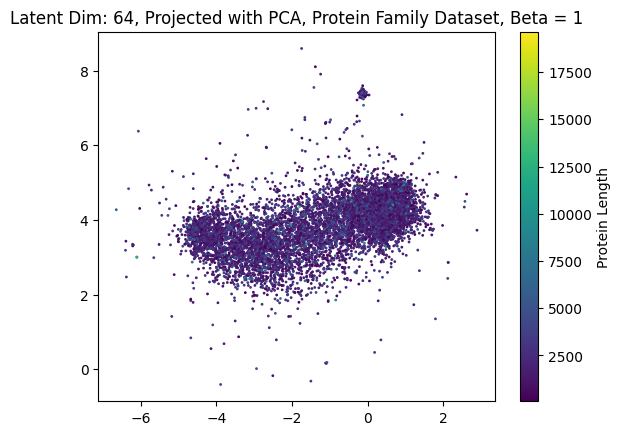

In [53]:
import matplotlib.pyplot as plt
plt.scatter(projected_data[:, 0], projected_data[:, 1], s = 1, c=lengths[:projected_data.shape[0]], cmap='viridis')
plt.colorbar(label = 'Protein Length')
plt.title('Latent Dim: 64, Projected with PCA, Protein Family Dataset, Beta = 1')
# plt.savefig("exp_1_latent_Pfam.png")

In [54]:
from collections import Counter
# Example list of strings
# protein_families = families[:projected_data.shape[0]]
# Count occurrences of each element
protein_families = families
counter = Counter(protein_families)

# Get the most common element (returns a list of tuples (element, count))
most_common = counter.most_common(1)

# Extract the most common string
if most_common:
    most_common_string = 'PF00074' #most_common[0][0]  # The string of the most common element
else:
    most_common_string = None

print(f"The most common protein family is: {most_common_string}")
N = 10
most_common_keys = [key for key, _ in counter.most_common(N)]

for most_common_string in most_common_keys:
    family_array = np.array(protein_families)
    most_common_indices = np.where((family_array == most_common_string) == 1)
    most_common_points = projected_data[most_common_indices, :]

    plt.scatter(projected_data[:, 0], projected_data[:, 1], s = 2, c=lengths[:projected_data.shape[0]],)
    plt.scatter(most_common_points.squeeze()[:, 0], most_common_points.squeeze()[:, 1], s = 4, c='r')

    plt.colorbar(label = 'Protein Length')
    plt.title('Latent Dim: 64, Projected with PCA, Protein Family Dataset, Beta = 1')
    plt.show()

NameError: name 'families' is not defined